In [2]:
import cv2
import numpy as np
import time

def reorder_corners(corners):
    # Sort the points based on their x and y coordinates
    sorted_corners = sorted(corners, key=lambda x: x[0])  # Sort by x coordinate first
    top_left, top_right = sorted_corners[:2]
    bottom_left, bottom_right = sorted_corners[2:]

    # Further sort the top-left and top-right by their y-coordinate
    if top_left[1] > top_right[1]:
        top_left, top_right = top_right, top_left

    if bottom_left[1] > bottom_right[1]:
        bottom_left, bottom_right = bottom_right, bottom_left

    return np.array([top_left, top_right, bottom_left, bottom_right])
# Existing circle detection code
def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 1)
    edges = cv2.Canny(gray, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            approx = reorder_corners(approx.reshape(4, 2))
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(contour)
            if 0.8 <= aspect_ratio <= 1.2 and area > 50000:
                return approx, x, y, w, h
    return None, None, None, None, None

# New dice detection code
def create_tracker(tracker_type="CSRT"):
    if tracker_type == "CSRT":
        return cv2.TrackerCSRT_create()
    elif tracker_type == "KCF":
        return cv2.TrackerKCF_create()
    return None

def draw_bbox_with_area(frame, bbox, color=(255, 255, 255)):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)
    text_position = (p1[0], max(0, p1[1] - 10))
    cv2.putText(frame, "Dice", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

def is_square(bbox, tolerance=0.2):
    x, y, w, h = bbox
    aspect_ratio = w / h if w > h else h / w
    return 1 - tolerance <= aspect_ratio <= 1 + tolerance

def is_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper, threshold=0.3):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    orange_mask = cv2.inRange(hsv_roi, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_roi, blue_lower, blue_upper)
    orange_pixels = cv2.countNonZero(orange_mask)
    blue_pixels = cv2.countNonZero(blue_mask)
    total_pixels = w * h
    return (orange_pixels + blue_pixels) / total_pixels >= threshold


def compute_circle_size_and_tolerance():
    circle_size = 50  # Average circle radius in pixels
    tolerance = 0.07 * circle_size
    return circle_size, tolerance


def stabilize_circles(new_circles, previous_circles, alpha=1, distance_threshold=20):
    if previous_circles is None:
        return new_circles

    stabilized_circles = []
    for new_circle in new_circles:
        x_new, y_new, r_new = new_circle
        matched = False
        for prev_circle in previous_circles:
            x_prev, y_prev, r_prev = prev_circle
            distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
            if distance < distance_threshold:
                x_stabilized = alpha * x_prev + (1 - alpha) * x_new
                y_stabilized = alpha * y_prev + (1 - alpha) * y_new
                r_stabilized = alpha * r_prev + (1 - alpha) * r_new
                stabilized_circles.append((x_stabilized, y_stabilized, r_stabilized))
                matched = True
                break
        if not matched:
            stabilized_circles.append(new_circle)

    return stabilized_circles



def detect_circles_and_dice_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    circle_size, tolerance = compute_circle_size_and_tolerance()
    previous_circles = None
    start_time = None
    finish_triggered = False
    no_circle_duration = 4
    circle_check_interval = 0.033

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    board_corners = board.reshape(4, 2)
    bottom_left = board_corners[1]
    bottom_right = board_corners[3]
    square_side = int(w * 0.23)
    roi_size = (square_side, square_side)

    orange_lower = np.array([4, 66, 114])
    orange_upper = np.array([15, 252, 253])
    blue_lower = np.array([90, 80, 100])
    blue_upper = np.array([120, 255, 255])


    trackers = []
    tracker_start_times = {}
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)
        
    #------------------------------------------- FINISH DETECTION by empty circles
        empty_circle_count = 0
        
        empty_circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, 
            dp=1.2, minDist=50, 
            param1=200, param2=100, 
            minRadius=int(circle_size - tolerance*4),
            maxRadius=int(circle_size + tolerance*2))
        
        
        if empty_circles is not None:
            empty_circles = np.uint16(np.around(empty_circles))
            for circle in empty_circles[0, :]:
                x, y, r = circle
                empty_circle_count +=1 
                # Create a circular mask for the detected circle
                mask = np.zeros_like(gray, dtype=np.uint8)
                cv2.circle(mask, (x, y), r, 255, -1)

                # Get dominant color inside the circle
                # dominant_color = get_dominant_color(frame, mask)
                # color_name = f"RGB({dominant_color[2]}, {dominant_color[1]}, {dominant_color[0]})"

                # Draw the circle and bounding box
                # cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
                cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (255, 255, 255), -1)

                # Put text (dominant color)
                # cv2.putText(frame, color_name, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(frame, "EMPTY", (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        if empty_circle_count == 0:
            if start_time is None:
                start_time = time.time()
            elif time.time() - start_time > no_circle_duration:
                finish_triggered = True
        else:
            start_time = None
            finish_triggered = False
            
        if finish_triggered:
            cv2.putText(frame, "Game Won", (400,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    # ---------------------------------------
        #detecting the circles -> animal tokens (also the empty board animals)

        circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
            param1=70, param2=30,
            minRadius=int(circle_size - tolerance),
            maxRadius=int(circle_size + tolerance)
        )
        
        if circles is not None:
            circles = np.uint16(np.around(circles))[0, :]
            stabilized_circles = stabilize_circles(circles, previous_circles)
            previous_circles = stabilized_circles

            for circle in stabilized_circles:
                x, y, r = map(int, circle)
                # Draw the circle on the frame
                cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
        
        
        #-------------------


        cv2.polylines(frame, [board[[2,0,1,3]]], isClosed=True, color=(255, 0, 255), thickness=4)

        roi_bottom_right = (
            int(bottom_left[0] + (square_side//7)),
            int(bottom_left[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

#Not detecting inside board
        frame_with_border_masked = frame.copy()
        cv2.rectangle(frame_with_border_masked, board[0], 
                      board[3], (0, 0, 0), -1)
#detect dog as circles, determine dog boxes
        roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

        circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)

        circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)
#Show number of dogs
        dogs_stats1 = f"Small dogs: {np.count_nonzero(circles_right)}"
        dogs_stats2 = f"Big dogs: {np.count_nonzero(circles_left)}"
        cv2.putText(frame, dogs_stats1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)
        cv2.putText(frame, dogs_stats2, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)

#visualise left dogs
        if circles_left is not None:
            circles_left = np.uint16(np.around(circles_left))
            for circle in circles_left[0, :]:
                cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)
#visualise right dogs
        if circles_right is not None:
            circles_right = np.uint16(np.around(circles_right))
            for circle in circles_right[0, :]:
                cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

# Detect dice
        hsv_frame = cv2.cvtColor(frame_with_border_masked, cv2.COLOR_BGR2HSV)
        orange_mask = cv2.inRange(hsv_frame, orange_lower, orange_upper)
        blue_mask = cv2.inRange(hsv_frame, blue_lower, blue_upper)
        combined_mask = cv2.bitwise_or(orange_mask, blue_mask)
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detected_bboxes = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if 1000 < area < 4500:
                x, y, w, h = cv2.boundingRect(contour)
                if is_square((x, y, w, h)):
                    detected_bboxes.append((x, y, w, h, area))

        current_time = time.time()
        
        for bbox_data in detected_bboxes:
            bbox = bbox_data[:4]
            is_new = True
            for tracker, tracked_bbox in trackers:
                if is_overlap(bbox, tracked_bbox):
                    is_new = False
                    break

            if is_new and is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                tracker = create_tracker("KCF")
                tracker.init(frame, bbox)
                trackers.append((tracker, bbox))
                tracker_start_times[tracker] = current_time

        for i, (tracker, _) in enumerate(trackers):
            ok, bbox = tracker.update(frame)
            if ok:
                if is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                    trackers[i] = (tracker, bbox)
                    area = bbox[2] * bbox[3]
                    draw_bbox_with_area(frame, bbox, (0, 255, 0))
                    
                    if current_time - tracker_start_times[tracker] >= 2:
                        text_position = (bbox[0], bbox[1] - 10)
                        cv2.putText(frame, "Dice Rolled", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            
                    
                else:
                    trackers[i] = None
            else:
                trackers[i] = None

        trackers = [t for t in trackers if t is not None]
        cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.polylines(frame, [board[[2, 0, 1, 3]]], isClosed=True, color=(255, 0, 255), thickness=4)
        cv2.imshow("Circles and Dice in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
# detect_circles_and_dice_in_video('./materials/12.MP4')
# detect_circles_and_dice_in_video('./materials/E2.mp4')
# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H3.MP4')

# ##Mary's
# detect_circles_and_dice_in_video('./materials/E1-T-W.MP4')
# detect_circles_and_dice_in_video('./materials/E2-T-L-W.MP4')
detect_circles_and_dice_in_video('./materials/E3-fastFinish.MP4')
# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H3-shake-win.MP4')

C:\Users\mary9\AppData\Local\Temp\ipykernel_2304\1092716269.py:92: RuntimeWarning: overflow encountered in scalar subtract
  distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
C:\Users\mary9\AppData\Local\Temp\ipykernel_2304\1092716269.py:92: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)


: 

# 

In [17]:
import cv2
import numpy as np
import time

def reorder_corners(corners):
    # Sort the points based on their x and y coordinates
    sorted_corners = sorted(corners, key=lambda x: x[0])  # Sort by x coordinate first
    top_left, top_right = sorted_corners[:2]
    bottom_left, bottom_right = sorted_corners[2:]

    # Further sort the top-left and top-right by their y-coordinate
    if top_left[1] > top_right[1]:
        top_left, top_right = top_right, top_left

    if bottom_left[1] > bottom_right[1]:
        bottom_left, bottom_right = bottom_right, bottom_left

    return np.array([top_left, top_right, bottom_left, bottom_right])
# Existing circle detection code
def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 1)
    edges = cv2.Canny(gray, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            approx = reorder_corners(approx.reshape(4, 2))
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(contour)
            if 0.8 <= aspect_ratio <= 1.2 and area > 50000:
                return approx, x, y, w, h
    return None, None, None, None, None

# New dice detection code
def create_tracker(tracker_type="CSRT"):
    if tracker_type == "CSRT":
        return cv2.TrackerCSRT_create()
    elif tracker_type == "KCF":
        return cv2.TrackerKCF_create()
    return None

def draw_bbox_with_area(frame, bbox, color=(255, 255, 255)):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)
    text_position = (p1[0], max(0, p1[1] - 10))
    cv2.putText(frame, "Dice", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

def is_square(bbox, tolerance=0.2):
    x, y, w, h = bbox
    aspect_ratio = w / h if w > h else h / w
    return 1 - tolerance <= aspect_ratio <= 1 + tolerance

def is_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper, threshold=0.3):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    orange_mask = cv2.inRange(hsv_roi, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_roi, blue_lower, blue_upper)
    orange_pixels = cv2.countNonZero(orange_mask)
    blue_pixels = cv2.countNonZero(blue_mask)
    total_pixels = w * h
    return (orange_pixels + blue_pixels) / total_pixels >= threshold


def compute_circle_size_and_tolerance():
    circle_size = 50  # Average circle radius in pixels
    tolerance = 0.07 * circle_size
    return circle_size, tolerance


def stabilize_circles(new_circles, previous_circles, alpha=1, distance_threshold=20):
    if previous_circles is None:
        return new_circles

    stabilized_circles = []
    for new_circle in new_circles:
        x_new, y_new, r_new = new_circle
        matched = False
        for prev_circle in previous_circles:
            x_prev, y_prev, r_prev = prev_circle
            distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
            if distance < distance_threshold:
                x_stabilized = alpha * x_prev + (1 - alpha) * x_new
                y_stabilized = alpha * y_prev + (1 - alpha) * y_new
                r_stabilized = alpha * r_prev + (1 - alpha) * r_new
                stabilized_circles.append((x_stabilized, y_stabilized, r_stabilized))
                matched = True
                break
        if not matched:
            stabilized_circles.append(new_circle)

    return stabilized_circles



def detect_circles_and_dice_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    circle_size, tolerance = compute_circle_size_and_tolerance()
    previous_circles = None
    start_time = None
    finish_triggered = False
    no_circle_duration = 4
    circle_check_interval = 0.033

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    board_corners = board.reshape(4, 2)
    bottom_left = board_corners[1]
    bottom_right = board_corners[3]
    square_side = int(w * 0.23)
    roi_size = (square_side, square_side)

    orange_lower = np.array([4, 66, 114])
    orange_upper = np.array([15, 252, 253])
    blue_lower = np.array([90, 80, 100])
    blue_upper = np.array([120, 255, 255])


    trackers = []
    tracker_start_times = {}
    
    
    #for traiding:
    buffer = int(max(w,h)*0.15)
    extended_board_rect = (
        x - buffer,
        y - buffer,
        x + w + buffer,
        y + h + buffer
    )

    circle_outside_count = {}
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)
        
    #------------------------------------------- FINISH DETECTION by empty circles
        empty_circle_count = 0
        
        empty_circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, 
            dp=1.2, minDist=50, 
            param1=200, param2=100, 
            minRadius=int(circle_size - tolerance*4),
            maxRadius=int(circle_size + tolerance*2))
        
        
        if empty_circles is not None:
            empty_circles = np.uint16(np.around(empty_circles))
            for circle in empty_circles[0, :]:
                x, y, r = circle
                empty_circle_count +=1 
                # Create a circular mask for the detected circle
                mask = np.zeros_like(gray, dtype=np.uint8)
                cv2.circle(mask, (x, y), r, 255, -1)

                # Get dominant color inside the circle
                # dominant_color = get_dominant_color(frame, mask)
                # color_name = f"RGB({dominant_color[2]}, {dominant_color[1]}, {dominant_color[0]})"

                # Draw the circle and bounding box
                # cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
                cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (255, 255, 255), -1)

                # Put text (dominant color)
                # cv2.putText(frame, color_name, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(frame, "EMPTY", (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        if empty_circle_count == 0:
            if start_time is None:
                start_time = time.time()
            elif time.time() - start_time > no_circle_duration:
                finish_triggered = True
        else:
            start_time = None
            finish_triggered = False
            
        if finish_triggered:
            cv2.putText(frame, "Game Won", (400,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    # ---------------------------------------
        #detecting the circles -> animal tokens (also the empty board animals)

        circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
            param1=70, param2=30,
            minRadius=int(circle_size - tolerance),
            maxRadius=int(circle_size + tolerance)
        )
        
        if circles is not None:
            circles = np.uint16(np.around(circles))[0, :]
            stabilized_circles = stabilize_circles(circles, previous_circles)
            previous_circles = stabilized_circles

            for circle in stabilized_circles:
                x, y, r = map(int, circle)
                # Draw the circle on the frame
                
#Determining what animal it is----------------------------------

                
#---------
                cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
                
                #check if the circle is outside the board for trading
                if not (extended_board_rect[0] <= x <= extended_board_rect[2] and
                        extended_board_rect[1] <= y <= extended_board_rect[3]):
                    if (x, y) not in circle_outside_count:
                        circle_outside_count[(x, y)] = 1
                    else:
                        circle_outside_count[(x, y)] += 1

                    if circle_outside_count[(x, y)] > 5:
                        cv2.putText(frame, "Trading in place", (400, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                else:
                    if (x, y) in circle_outside_count:
                        del circle_outside_count[(x, y)]
        
        
        #-------------------


        cv2.polylines(frame, [board[[2,0,1,3]]], isClosed=True, color=(255, 0, 255), thickness=4)

        roi_bottom_right = (
            int(bottom_left[0] + (square_side//7)),
            int(bottom_left[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

#Not detecting inside board
        frame_with_border_masked = frame.copy()
        cv2.rectangle(frame_with_border_masked, board[0], 
                      board[3], (0, 0, 0), -1)
#detect dog as circles, determine dog boxes
        roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

        circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)

        circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)
#Show number of dogs
        dogs_stats1 = f"Small dogs: {np.count_nonzero(circles_right)}"
        dogs_stats2 = f"Big dogs: {np.count_nonzero(circles_left)}"
        cv2.putText(frame, dogs_stats1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)
        cv2.putText(frame, dogs_stats2, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)

#visualise left dogs
        if circles_left is not None:
            circles_left = np.uint16(np.around(circles_left))
            for circle in circles_left[0, :]:
                cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)
#visualise right dogs
        if circles_right is not None:
            circles_right = np.uint16(np.around(circles_right))
            for circle in circles_right[0, :]:
                cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

# Detect dice
        hsv_frame = cv2.cvtColor(frame_with_border_masked, cv2.COLOR_BGR2HSV)
        orange_mask = cv2.inRange(hsv_frame, orange_lower, orange_upper)
        blue_mask = cv2.inRange(hsv_frame, blue_lower, blue_upper)
        combined_mask = cv2.bitwise_or(orange_mask, blue_mask)
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detected_bboxes = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if 1000 < area < 4500:
                x, y, w, h = cv2.boundingRect(contour)
                if is_square((x, y, w, h)):
                    detected_bboxes.append((x, y, w, h, area))

        current_time = time.time()
        
        for bbox_data in detected_bboxes:
            bbox = bbox_data[:4]
            is_new = True
            for tracker, tracked_bbox in trackers:
                if is_overlap(bbox, tracked_bbox):
                    is_new = False
                    break

            if is_new and is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                tracker = create_tracker("KCF")
                tracker.init(frame, bbox)
                trackers.append((tracker, bbox))
                tracker_start_times[tracker] = current_time

        for i, (tracker, _) in enumerate(trackers):
            ok, bbox = tracker.update(frame)
            if ok:
                if is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                    trackers[i] = (tracker, bbox)
                    area = bbox[2] * bbox[3]
                    draw_bbox_with_area(frame, bbox, (0, 255, 0))
                    print(bbox)
                    
#Dice rolled event trigger-------------------------------
                    if current_time - tracker_start_times[tracker] >= 1:
                        text_position = (bbox[0], bbox[1] - 10)
                        cv2.putText(frame, "Dice Rolled", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

#DETECTING FOR WOOLF-------------------------------------- NOTHING REALLY DONE.
                        # #check similarity
                        # x_wolf,y_wolf,w_wolf,h_wolf = bbox
                        # dice_to_detect = frame[y_wolf:y_wolf+h_wolf, x_wolf:x_wolf+w_wolf]
                        
                        # dice_to_detect = cv2.Canny(dice_to_detect, 50, 150)
                        # cv2.imshow("frame{i}", dice_to_detect)
                    
                else:
                    trackers[i] = None
            else:
                trackers[i] = None

        trackers = [t for t in trackers if t is not None]
        cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.polylines(frame, [board[[2, 0, 1, 3]]], isClosed=True, color=(255, 0, 255), thickness=4)
        cv2.imshow("Circles and Dice in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
# detect_circles_and_dice_in_video('./materials/E3.MP4')
# detect_circles_and_dice_in_video('./materials/E2.mp4')
# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H3.MP4')

# ##Mary's
detect_circles_and_dice_in_video('./materials/E1-T-W.MP4')
# detect_circles_and_dice_in_video('./materials/E2-T-L-W.MP4')
# detect_circles_and_dice_in_video('./materials/E3-fastFinish.MP4')
# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H3-shake-win.MP4')

Error: Could not open video.


# working on pattern matching
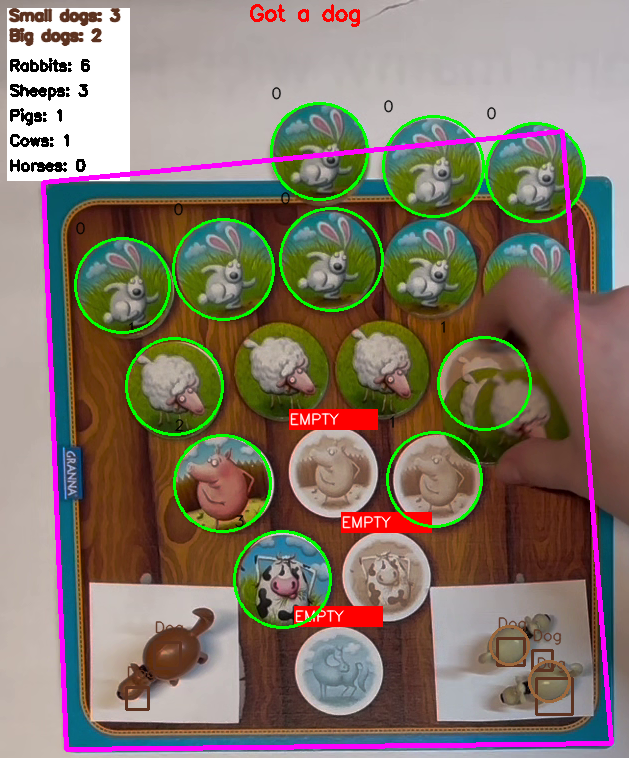

In [15]:
import cv2
import numpy as np
import time

def reorder_corners(corners):
    # Sort the points based on their x and y coordinates
    sorted_corners = sorted(corners, key=lambda x: x[0])  # Sort by x coordinate first
    top_left, top_right = sorted_corners[:2]
    bottom_left, bottom_right = sorted_corners[2:]

    # Further sort the top-left and top-right by their y-coordinate
    if top_left[1] > top_right[1]:
        top_left, top_right = top_right, top_left

    if bottom_left[1] > bottom_right[1]:
        bottom_left, bottom_right = bottom_right, bottom_left

    return np.array([top_left, top_right, bottom_left, bottom_right])
# Existing circle detection code
def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 1)
    edges = cv2.Canny(gray, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            approx = reorder_corners(approx.reshape(4, 2))
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(contour)
            if 0.8 <= aspect_ratio <= 1.2 and area > 50000:
                return approx, x, y, w, h
    return None, None, None, None, None

# New dice detection code
def create_tracker(tracker_type="CSRT"):
    if tracker_type == "CSRT":
        return cv2.TrackerCSRT_create()
    elif tracker_type == "KCF":
        return cv2.TrackerKCF_create()
    elif tracker_type == "MIL":
        return cv2.TrackerMIL_create()
    elif tracker_type == "BOOSTING":
        return cv2.TrackerBoosting_create()
    return None

def draw_bbox_with_area(frame, bbox, text, color=(255, 255, 255)):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)
    text_position = (p1[0], max(0, p1[1] - 10))
    cv2.putText(frame, text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

def is_square(bbox, tolerance=0.2):
    x, y, w, h = bbox
    aspect_ratio = w / h if w > h else h / w
    return 1 - tolerance <= aspect_ratio <= 1 + tolerance

def is_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def is_overlap_with_tolerance(bbox1, bbox2, tolerance=1.2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # Calculate the intersection coordinates
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2)
    inter_y2 = min(y1 + h1, y2 + h2)

    # Check if there is no intersection
    if inter_x1 >= inter_x2 or inter_y1 >= inter_y2:
        return False

    # Calculate intersection area
    inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)

    # Calculate the areas of both boxes
    area1 = w1 * h1
    area2 = w2 * h2

    # Calculate average area
    avg_area = (area1 + area2) / 2

    # Calculate the overlap ratio
    overlap_ratio = inter_area / avg_area

    # Return whether the overlap ratio is within the tolerance
    return overlap_ratio > tolerance


def is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper, threshold=0.3):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    orange_mask = cv2.inRange(hsv_roi, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_roi, blue_lower, blue_upper)
    orange_pixels = cv2.countNonZero(orange_mask)
    blue_pixels = cv2.countNonZero(blue_mask)
    total_pixels = w * h
    return (orange_pixels + blue_pixels) / total_pixels >= threshold


def compute_circle_size_and_tolerance():
    circle_size = 50  # Average circle radius in pixels
    tolerance = 0.07 * circle_size
    return circle_size, tolerance


def stabilize_circles(new_circles, previous_circles, alpha=1, distance_threshold=20):
    if previous_circles is None:
        return new_circles

    stabilized_circles = []
    for new_circle in new_circles:
        x_new, y_new, r_new = new_circle
        matched = False
        for prev_circle in previous_circles:
            x_prev, y_prev, r_prev = prev_circle
            distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
            if distance < distance_threshold:
                x_stabilized = alpha * x_prev + (1 - alpha) * x_new
                y_stabilized = alpha * y_prev + (1 - alpha) * y_new
                r_stabilized = alpha * r_prev + (1 - alpha) * r_new
                stabilized_circles.append((x_stabilized, y_stabilized, r_stabilized))
                matched = True
                break
        if not matched:
            stabilized_circles.append(new_circle)

    return stabilized_circles

def extract_circle_region(frame, x, y, r):
    """
    Extracts the region of the frame inside a given circle.

    Parameters:
        frame (numpy.ndarray): The video frame.
        x (int): X-coordinate of the circle's center.
        y (int): Y-coordinate of the circle's center.
        r (int): Radius of the circle.

    Returns:
        numpy.ndarray: The cropped circular region.
    """
    # Create a mask with the same size as the frame
    mask = np.zeros_like(frame, dtype=np.uint8)

    # Draw a filled circle on the mask
    cv2.circle(mask, (x, y), r, (255, 255, 255), -1)

    # Apply the mask to the frame
    circular_region = cv2.bitwise_and(frame, mask)

    # Crop the bounding box around the circle
    x_min, y_min = max(0, x - r), max(0, y - r)
    x_max, y_max = min(frame.shape[1], x + r), min(frame.shape[0], y + r)
    cropped_region = circular_region[y_min:y_max, x_min:x_max]

    return cropped_region

def resize_region(region, template):
    """
    Resizes the detected region to the size of the template.
    
    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        template (numpy.ndarray): Template image to match against.

    Returns:
        numpy.ndarray: Resized detected region.
    """
    return cv2.resize(region, (template.shape[1], template.shape[0]))


def match_templates(region, templates):
    """
    Matches the detected region with each template using template matching.
    
    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        templates (list): List of template images.

    Returns:
        int: Index of the most similar template.
        float: Matching score of the best match.
    """
    best_match_idx = -1
    best_score = float('-inf')

    for i, template in enumerate(templates):
        # cv2.imshow("template", template)
        # Resize the region to match the template size
        resized_region = resize_region(region, template)
        
        # Perform template matching
        result = cv2.matchTemplate(resized_region, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        
        # Keep track of the best match
        if max_val > best_score:
            best_score = max_val
            best_match_idx = i

    return best_match_idx, best_score

def orb_match(fragment_gray, template_gray, match_threshold=15):
    """
    Matches features between a frame fragment and a template using ORB.

    Parameters:
        frame_fragment (numpy.ndarray): The image fragment to check.
        template (numpy.ndarray): The template to compare against.
        match_threshold (int): Minimum number of good matches to confirm a match.

    Returns:
        bool: True if the fragment matches the template, False otherwise.
    """
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(fragment_gray, None)
    kp2, des2 = orb.detectAndCompute(template_gray, None)

    # Check if descriptors are valid
    if des1 is None or des2 is None or len(des1) == 0 or len(des2) == 0:
        return False

    # Ensure descriptors have matching types
    if des1.dtype != des2.dtype:
        des2 = des2.astype(des1.dtype)

    # Use BFMatcher to find matches
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Filter matches by distance
    good_matches = [m for m in matches if m.distance < 30]  # Adjust threshold as needed

    # Check if the number of good matches exceeds the threshold
    return len(good_matches) >= match_threshold


def template_match(frame_fragment, template, threshold=0.6):
    """
    Determines if the template exists in the frame fragment using template matching.

    Parameters:
        frame_fragment (numpy.ndarray): The fragment of the video frame.
        template (numpy.ndarray): The template image to be matched.
        threshold (float): Minimum similarity threshold for a match.

    Returns:
        bool: True if the template matches the frame fragment, False otherwise.
    """
    # Perform template matching
    result = cv2.matchTemplate(frame_fragment, template, cv2.TM_SQDIFF_NORMED)
    
    #todelete
    # cv2.imshow("frame",frame_fragment)
    # cv2.imshow("wolf",template)
    # if cv2.waitKey(2000) & 0xFF == ord('q'):
    #     cv2.destroyWindow("frame")
    #     cv2.destroyWindow("wolf")
    #
    # Find the maximum similarity value
    _, max_val, _, _ = cv2.minMaxLoc(result)

    # Return True if the maximum value exceeds the threshold
    return max_val >= threshold


def match_features(region, templates):
    """
    Matches the detected region with each template using feature matching.

    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        templates (list): List of template images.

    Returns:
        int: Index of the most similar template.
        float: Matching score of the best match.
    """
    orb = cv2.ORB_create()
    best_match_idx = -1
    best_score = 0

    # Convert the region to grayscale
    region_gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors for the region
    kp1, des1 = orb.detectAndCompute(region_gray, None)

    for i, template in enumerate(templates):
        # Convert the template to grayscale
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

        # Detect keypoints and descriptors for the template
        kp2, des2 = orb.detectAndCompute(template_gray, None)

        # Match features using BFMatcher
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)

        # Sort matches by distance
        matches = sorted(matches, key=lambda x: x.distance)

        # Calculate the score as the number of good matches
        score = len(matches)
        if score > best_score:
            best_score = score
            best_match_idx = i

    return best_match_idx, best_score




def detect_circles_and_dice_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    circle_size, tolerance = compute_circle_size_and_tolerance()
    previous_circles = None
    start_time = None
    finish_triggered = False
    no_circle_duration = 4
    circle_check_interval = 0.033

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    board_corners = board.reshape(4, 2)
    bottom_left = board_corners[1]
    bottom_right = board_corners[3]
    square_side = int(w * 0.23)
    roi_size = (square_side, square_side)

    orange_lower = np.array([4, 66, 114])
    orange_upper = np.array([15, 252, 253])
    blue_lower = np.array([90, 80, 100])
    blue_upper = np.array([120, 255, 255])


    trackers = []
    left_dog_trackers =[]
    right_dog_trackers =[]
    tracker_start_times = {}
    tracker_dog_start_times = {}
    
    
    #for traiding:
    buffer = int(max(w,h)*0.15)
    extended_board_rect = (
        x - buffer,
        y - buffer,
        x + w + buffer,
        y + h + buffer
    )

    circle_outside_count = {}
    
    #for animal detection
    templates = [
            cv2.imread("./materials/rabbit.png"),
            cv2.imread("./materials/sheep.png"),
            cv2.imread("./materials/pig.png"),
            cv2.imread("./materials/cow.png"),
            cv2.imread("./materials/horse.png")
            ]
    # wolf_template = cv2.imread("./materials/wolf_template.jpg", cv2.IMREAD_GRAYSCALE)
    # wolf_template = cv2.imread("./materials/wolf.png", cv2.IMREAD_GRAYSCALE)
    wolf_template = cv2.imread("./materials/wolf_upright.png", cv2.IMREAD_GRAYSCALE)
    
    #for tracking dog buying
    tracker_display_counters_left = {}
    tracker_display_counters_right = {}
    display_duration = 30

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)        
        
    #------------------------------------------- FINISH DETECTION by empty circles
        empty_circle_count = 0
        empty_circles_coordinates =[]
        
        empty_circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, 
            dp=1.2, minDist=50, 
            param1=200, param2=95, 
            minRadius=int(circle_size - tolerance*4),
            maxRadius=int(circle_size + tolerance*2))
        
        
        if empty_circles is not None:
            empty_circles = np.uint16(np.around(empty_circles))
            for circle in empty_circles[0, :]:
                x, y, r = circle
                empty_circles_coordinates.append((x,y))
                empty_circle_count +=1 
                # Create a circular mask for the detected circle
                mask = np.zeros_like(gray, dtype=np.uint8)
                cv2.circle(mask, (x, y), r, 255, -1)

                # Get dominant color inside the circle
                # dominant_color = get_dominant_color(frame, mask)
                # color_name = f"RGB({dominant_color[2]}, {dominant_color[1]}, {dominant_color[0]})"
                ## Draw the circle and bounding box
                # cv2.circle(frame, (x, y), r, (0,0,255), 2)
                ##checking whats the reason for false positives on empty spaces
                # Put text (dominant color)
                # cv2.putText(frame, color_name, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                
                #debugging empty
                cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (0,0,255), -1)
                cv2.putText(frame, "EMPTY", (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
        
        if empty_circle_count == 0:
            if start_time is None:
                start_time = time.time()
            elif time.time() - start_time > no_circle_duration:
                finish_triggered = True
        else:
            start_time = None
            finish_triggered = False
            
        if finish_triggered:
            cv2.putText(frame, "Game Won", (400,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    # ---------------------------------------
        #detecting the circles -> animal tokens (also the empty board animals)

        circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
            param1=70, param2=30,
            minRadius=int(circle_size - tolerance),
            maxRadius=int(circle_size + tolerance)
        )
        
        if circles is not None:
            circles = np.uint16(np.around(circles))[0, :]
            stabilized_circles = stabilize_circles(circles, previous_circles)
            previous_circles = stabilized_circles

            detected_animals=[0, 0, 0, 0, 0]
            
            for circle in stabilized_circles:
                x, y, r = map(int, circle)
                
                skip_circle = False
                for coord_x, coord_y in empty_circles_coordinates:
                    distance = np.sqrt((coord_x - x)**2 + (coord_y - y)**2)
                    if distance <= r+12:
                        skip_circle = True
                        break  # Skip further checks for this circle
                
                if skip_circle:
                    continue
                
            #Determining what animal it is----------------------------------
                animal = extract_circle_region(frame, x, y, r)
                # cv2.imshow("animal", animal)
                # cv2.imshow("templates", template[0])
                best_match_idx, best_score = match_templates(animal, templates)
                # best_match_idx, best_score = match_features(animal, templates)                
                detected_animals[best_match_idx] += 1
            #--------------------------------------------------------------

                # Draw the circle on the frame
                cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
                #todelete
                cv2.putText(frame, f"{best_match_idx}", (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                #
                
            #Determining trading --------------               
                #check if the circle is outside the board for trading
                if not (extended_board_rect[0] <= x <= extended_board_rect[2] and
                        extended_board_rect[1] <= y <= extended_board_rect[3]):
                    if (x, y) not in circle_outside_count:
                        circle_outside_count[(x, y)] = 1
                    else:
                        circle_outside_count[(x, y)] += 1

                    if circle_outside_count[(x, y)] > 5:
                        # cv2.rectangle()
                        cv2.putText(frame, "Trading in place", (400, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                else:
                    if (x, y) in circle_outside_count:
                        del circle_outside_count[(x, y)]
            #-------------------------------
        
        #printing status of the game---------------
            cv2.rectangle(frame, (8, 8), (130, 180), (255, 255, 255), -1)
            cv2.putText(frame, f"Rabbits: {detected_animals[0]}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Sheeps: {detected_animals[1]}", (10, 95), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Pigs: {detected_animals[2]}", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Cows: {detected_animals[3]}", (10, 145), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Horses: {detected_animals[4]}", (10, 170), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        #-------------------------------------------


        cv2.polylines(frame, [board[[2,0,1,3]]], isClosed=True, color=(255, 0, 255), thickness=4)

        roi_bottom_right = (
            int(bottom_left[0] + (square_side//7)),
            int(bottom_left[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

#Not detecting inside board
        frame_with_border_masked = frame.copy()
        cv2.rectangle(frame_with_border_masked, board[0], 
                      board[3], (0, 0, 0), -1)
#detect dog as circles, determine dog boxes
        roi_frame_right = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_left = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)
        
        l=cv2.GaussianBlur(roi_gray_left, (5, 5), 1.4)
        r=cv2.GaussianBlur(roi_gray_right, (5, 5), 1.4)
        l_can = cv2.Canny(l, 80, 150)
        r_can = cv2.Canny(r, 80, 150)
        contours_l, _ = cv2.findContours(l_can, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_r, _ = cv2.findContours(r_can, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        print(contours_l)
        filtered_contours_l = [cnt for cnt in contours_l if cv2.contourArea(cnt) > 100]
        filtered_contours_r = [cnt for cnt in contours_r if cv2.contourArea(cnt) > 100]
        for cnt in filtered_contours_l:
            (x, y, w, h) = cv2.boundingRect(cnt)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        for cnt in filtered_contours_r:
            (x, y, w, h) = cv2.boundingRect(cnt)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # cv2.imshow("buja", )
        # cv2.imshow("buja2", cv2.Canny(r, 80, 150))
        # key = cv2.waitKey(1) & 0xFF
        # if key == ord('w'):  # Close windows when 'w' is pressed
        #     cv2.destroyWindow("buja")
        #     cv2.destroyWindow("buja2")
        #     break
        #here look for the dog
        dog_time = time.time()
        dogs_bbox_left =[]
        dogs_bbox_right =[]
        
        minradius = int(circle_size//3)
        circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=minradius, maxRadius=50)

        circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=minradius, maxRadius=50)
        
        if circles_left is not None:
            for left_contour in circles_left[0]:
                # print((x-r, y-r, r*2, r*2))
                x, y, r = left_contour
                movement = r //2
                dogs_bbox_left.append((int(x-movement), int(y-movement), int(r), int(r)))           
            
        for bbox_data in dogs_bbox_left:
            bbox = bbox_data[:4]
            is_new = True
            for tracker, tracked_bbox in left_dog_trackers:
                if is_overlap(bbox, tracked_bbox):
                    is_new = False
                    break

            if is_new:
                tracker = create_tracker("KCF")
                tracker.init(frame, bbox)
                left_dog_trackers.append((tracker, bbox))
                tracker_dog_start_times[tracker] = dog_time
                # cv2.putText(frame, "Got a dog", (400,20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                tracker_display_counters_left[tracker] = display_duration

        for i, (tracker, _) in enumerate(left_dog_trackers):
            ok, bbox = tracker.update(frame)
            if ok:
                left_dog_trackers[i] = (tracker, bbox)
                area = bbox[2] * bbox[3]
                draw_bbox_with_area(frame, (roi_bottom_left[0] + bbox[0], roi_bottom_left[1] + bbox[1], bbox[2], bbox[3]), "Dog", (32, 50, 92))

                if tracker in tracker_display_counters_left and tracker_display_counters_left[tracker] > 0:
                    cv2.putText(frame, "Got a dog", (250, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                    tracker_display_counters_left[tracker] -= 1  # Decrement the counter

            else:
                print("not ok")
                left_dog_trackers[i] = None
                
                
        dogs_stats1 = f"Small dogs: {len(left_dog_trackers)}"
        left_dog_trackers = [t for t in left_dog_trackers if t is not None] 
#Small dogs
        if circles_right is not None:
            for right_contour in circles_right[0]:
                # print((x-r, y-r, r*2, r*2))
                x, y, r = right_contour
                dogs_bbox_right.append((int(x-movement), int(y-movement), int(r), int(r)))
        for bbox_data in dogs_bbox_right:
            bbox = bbox_data[:4]
            is_new = True
            for tracker, tracked_bbox in right_dog_trackers:
                if is_overlap(bbox, tracked_bbox):
                    is_new = False
                    break

            if is_new:
                tracker = create_tracker("KCF")
                tracker.init(frame, bbox)
                right_dog_trackers.append((tracker, bbox))
                tracker_dog_start_times[tracker] = dog_time
                
                tracker_display_counters_right[tracker] =30

        for i, (tracker, _) in enumerate(right_dog_trackers):
            ok, bbox = tracker.update(frame)
            if ok:
                right_dog_trackers[i] = (tracker, bbox)
                area = bbox[2] * bbox[3]
                draw_bbox_with_area(frame, (roi_bottom_right[0] + bbox[0], roi_bottom_right[1] + bbox[1], bbox[2], bbox[3]), "Dog", (32, 50, 92))

                if tracker in tracker_display_counters_right and tracker_display_counters_right[tracker] > 0:
                    cv2.putText(frame, "Got a dog", (250, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                    tracker_display_counters_right[tracker] -= 1  # Decrement the counter
            else:
                print("not ok")
                right_dog_trackers[i] = None
                
        dogs_stats2 = f"Big dogs: {len(right_dog_trackers)}"
        right_dog_trackers = [t for t in right_dog_trackers if t is not None]
#Show number of dogs
        
        cv2.putText(frame, dogs_stats1, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)
        cv2.putText(frame, dogs_stats2, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)

# #visualise left dogs
        if circles_left is not None:
            circles_left = np.uint16(np.around(circles_left))
            for circle in circles_left[0, :]:
                cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)
#visualise right dogs
        if circles_right is not None:
            circles_right = np.uint16(np.around(circles_right))
            for circle in circles_right[0, :]:
                cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

# Detect dice
        hsv_frame = cv2.cvtColor(frame_with_border_masked, cv2.COLOR_BGR2HSV)
        orange_mask = cv2.inRange(hsv_frame, orange_lower, orange_upper)
        blue_mask = cv2.inRange(hsv_frame, blue_lower, blue_upper)
        combined_mask = cv2.bitwise_or(orange_mask, blue_mask)
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detected_bboxes = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if 1000 < area < 4500:
                x, y, w, h = cv2.boundingRect(contour)
                if is_square((x, y, w, h)):
                    detected_bboxes.append((x, y, w, h, area))

        current_time = time.time()
        
        for bbox_data in detected_bboxes:
            bbox = bbox_data[:4]
            is_new = True
            for tracker, tracked_bbox in trackers:
                if is_overlap(bbox, tracked_bbox):
                    is_new = False
                    break

            if is_new and is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                tracker = create_tracker("KCF")
                tracker.init(frame, bbox)
                trackers.append((tracker, bbox))
                tracker_start_times[tracker] = current_time

        for i, (tracker, _) in enumerate(trackers):
            ok, bbox = tracker.update(frame)
            if ok:
                if is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                    trackers[i] = (tracker, bbox)
                    area = bbox[2] * bbox[3]
                    draw_bbox_with_area(frame, bbox, "Dice", (0, 255, 0))
                    
#Dice rolled event trigger-------------------------------
                    if current_time - tracker_start_times[tracker] >= 1:
                        text_position = (bbox[0], bbox[1] - 10)
                        cv2.putText(frame, "Dice Rolled", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

#DETECTING FOR WOOLF-------------------------------------- 
                        #check similarity
                        x_wolf,y_wolf,w_wolf,h_wolf = bbox
                        dice_to_detect = frame[y_wolf:y_wolf+h_wolf, x_wolf:x_wolf+w_wolf]
                        dice_to_detect = cv2.cvtColor(dice_to_detect, cv2.COLOR_BGR2GRAY)

                        # cv2.imshow("frame{i}", dice_to_detect)
                        # print(dice_to_detect.shape, wolf_template.shape)
                        template_height, template_width = wolf_template.shape[:2]
                        dice_resized = cv2.resize(dice_to_detect, (template_width, template_height), interpolation=cv2.INTER_AREA)
                        
                        #todelete
                        # cv2.imshow("frame",dice_resized)
                        # cv2.imshow("wolf",wolf_template)
                        # if cv2.waitKey(10) & 0xFF == ord('w'):
                        #     cv2.destroyWindow("frame")
                        #     cv2.destroyWindow("wolf")
                            
                        orb = orb_match(dice_resized, wolf_template)
                        tempmatch = template_match(dice_resized, wolf_template)
                        
                        if orb is True:
                            cv2.putText(frame, "Woolf detected by orb", (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 1 , (0, 0, 255), 2)
                        if tempmatch is True:
                            cv2.putText(frame, "Woolf detected", (400, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                else:
                    trackers[i] = None
            else:
                trackers[i] = None

        trackers = [t for t in trackers if t is not None]
        # cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
        # cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)
        # cv2.polylines(frame, [board[[2, 0, 1, 3]]], isClosed=True, color=(255, 0, 255), thickness=4)
        cv2.imshow("Circles and Dice in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
# detect_circles_and_dice_in_video('./materials/E3.MP4')
# detect_circles_and_dice_in_video('./materials/E2.mp4')
# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H3.MP4')

# ##Mary's
detect_circles_and_dice_in_video('./materials/E1.MP4')
# detect_circles_and_dice_in_video('./materials/E1-T-W.MP4')
# detect_circles_and_dice_in_video('./materials/E2-T-L-W.MP4')
# detect_circles_and_dice_in_video('./materials/E3-fastFinish.MP4')

# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H3-shake-win.MP4')

(array([[[115, 122]],

       [[113, 124]],

       [[112, 124]],

       [[111, 125]],

       [[109, 125]],

       [[108, 126]],

       [[107, 126]],

       [[106, 127]],

       [[102, 127]],

       [[101, 128]],

       [[ 99, 128]],

       [[ 99, 129]],

       [[100, 128]],

       [[103, 128]],

       [[104, 127]],

       [[106, 127]],

       [[107, 126]],

       [[109, 126]],

       [[110, 125]],

       [[112, 125]],

       [[113, 124]],

       [[114, 124]],

       [[116, 122]],

       [[117, 122]]], dtype=int32), array([[[113, 119]],

       [[112, 120]],

       [[ 93, 120]],

       [[ 92, 121]],

       [[ 70, 121]],

       [[ 69, 122]],

       [[ 52, 122]],

       [[ 51, 123]],

       [[ 28, 123]],

       [[ 27, 124]],

       [[  0, 124]],

       [[ 27, 124]],

       [[ 28, 123]],

       [[ 51, 123]],

       [[ 52, 122]],

       [[ 69, 122]],

       [[ 70, 121]],

       [[ 92, 121]],

       [[ 93, 120]],

       [[112, 120]],

       [[113, 119

C:\Users\mary9\AppData\Local\Temp\ipykernel_9512\1717924162.py:127: RuntimeWarning: overflow encountered in scalar subtract
  distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
C:\Users\mary9\AppData\Local\Temp\ipykernel_9512\1717924162.py:127: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)


(array([[[115, 122]],

       [[113, 124]],

       [[112, 124]],

       [[111, 125]],

       [[109, 125]],

       [[108, 126]],

       [[107, 126]],

       [[106, 127]],

       [[103, 127]],

       [[102, 128]],

       [[ 99, 128]],

       [[103, 128]],

       [[104, 127]],

       [[106, 127]],

       [[107, 126]],

       [[109, 126]],

       [[110, 125]],

       [[112, 125]],

       [[113, 124]],

       [[114, 124]],

       [[116, 122]],

       [[117, 122]]], dtype=int32), array([[[113, 119]],

       [[112, 120]],

       [[ 95, 120]],

       [[ 94, 121]],

       [[ 72, 121]],

       [[ 71, 122]],

       [[ 53, 122]],

       [[ 52, 123]],

       [[ 28, 123]],

       [[ 27, 124]],

       [[  0, 124]],

       [[ 27, 124]],

       [[ 28, 123]],

       [[ 52, 123]],

       [[ 53, 122]],

       [[ 71, 122]],

       [[ 72, 121]],

       [[ 94, 121]],

       [[ 95, 120]],

       [[112, 120]],

       [[113, 119]],

       [[124, 119]],

       [[125, 120

In [14]:
import cv2
import numpy as np
import time
from collections import deque


def reorder_corners(corners):
    # Sort the points based on their x and y coordinates
    sorted_corners = sorted(corners, key=lambda x: x[0])  # Sort by x coordinate first
    top_left, top_right = sorted_corners[:2]
    bottom_left, bottom_right = sorted_corners[2:]

    # Further sort the top-left and top-right by their y-coordinate
    if top_left[1] > top_right[1]:
        top_left, top_right = top_right, top_left

    if bottom_left[1] > bottom_right[1]:
        bottom_left, bottom_right = bottom_right, bottom_left

    return np.array([top_left, top_right, bottom_left, bottom_right])
# Existing circle detection code
def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 1)
    edges = cv2.Canny(gray, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            approx = reorder_corners(approx.reshape(4, 2))
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(contour)
            if 0.8 <= aspect_ratio <= 1.2 and area > 50000:
                return approx, x, y, w, h
    return None, None, None, None, None

# New dice detection code
def create_tracker(tracker_type="CSRT"):
    if tracker_type == "CSRT":
        return cv2.TrackerCSRT_create()
    elif tracker_type == "KCF":
        return cv2.TrackerKCF_create()
    elif tracker_type == "MIL":
        return cv2.TrackerMIL_create()
    elif tracker_type == "BOOSTING":
        return cv2.TrackerBoosting_create()
    return None

def draw_bbox_with_area(frame, bbox, text, color=(255, 255, 255)):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)
    text_position = (p1[0], max(0, p1[1] - 10))
    cv2.putText(frame, text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

def is_square(bbox, tolerance=0.2):
    x, y, w, h = bbox
    aspect_ratio = w / h if w > h else h / w
    return 1 - tolerance <= aspect_ratio <= 1 + tolerance

def is_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def is_overlap_with_tolerance(bbox1, bbox2, tolerance=1.2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # Calculate the intersection coordinates
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2)
    inter_y2 = min(y1 + h1, y2 + h2)

    # Check if there is no intersection
    if inter_x1 >= inter_x2 or inter_y1 >= inter_y2:
        return False

    # Calculate intersection area
    inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)

    # Calculate the areas of both boxes
    area1 = w1 * h1
    area2 = w2 * h2

    # Calculate average area
    avg_area = (area1 + area2) / 2

    # Calculate the overlap ratio
    overlap_ratio = inter_area / avg_area

    # Return whether the overlap ratio is within the tolerance
    return overlap_ratio > tolerance


def is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper, threshold=0.3):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    orange_mask = cv2.inRange(hsv_roi, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_roi, blue_lower, blue_upper)
    orange_pixels = cv2.countNonZero(orange_mask)
    blue_pixels = cv2.countNonZero(blue_mask)
    total_pixels = w * h
    return (orange_pixels + blue_pixels) / total_pixels >= threshold


def compute_circle_size_and_tolerance():
    circle_size = 50  # Average circle radius in pixels
    tolerance = 0.07 * circle_size
    return circle_size, tolerance


def stabilize_circles(new_circles, previous_circles, alpha=1, distance_threshold=20):
    if previous_circles is None:
        return new_circles

    stabilized_circles = []
    for new_circle in new_circles:
        x_new, y_new, r_new = new_circle
        matched = False
        for prev_circle in previous_circles:
            x_prev, y_prev, r_prev = prev_circle
            distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
            if distance < distance_threshold:
                x_stabilized = alpha * x_prev + (1 - alpha) * x_new
                y_stabilized = alpha * y_prev + (1 - alpha) * y_new
                r_stabilized = alpha * r_prev + (1 - alpha) * r_new
                stabilized_circles.append((x_stabilized, y_stabilized, r_stabilized))
                matched = True
                break
        if not matched:
            stabilized_circles.append(new_circle)

    return stabilized_circles

def extract_circle_region(frame, x, y, r):
    """
    Extracts the region of the frame inside a given circle.

    Parameters:
        frame (numpy.ndarray): The video frame.
        x (int): X-coordinate of the circle's center.
        y (int): Y-coordinate of the circle's center.
        r (int): Radius of the circle.

    Returns:
        numpy.ndarray: The cropped circular region.
    """
    # Create a mask with the same size as the frame
    mask = np.zeros_like(frame, dtype=np.uint8)

    # Draw a filled circle on the mask
    cv2.circle(mask, (x, y), r, (255, 255, 255), -1)

    # Apply the mask to the frame
    circular_region = cv2.bitwise_and(frame, mask)

    # Crop the bounding box around the circle
    x_min, y_min = max(0, x - r), max(0, y - r)
    x_max, y_max = min(frame.shape[1], x + r), min(frame.shape[0], y + r)
    cropped_region = circular_region[y_min:y_max, x_min:x_max]

    return cropped_region

def resize_region(region, template):
    """
    Resizes the detected region to the size of the template.
    
    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        template (numpy.ndarray): Template image to match against.

    Returns:
        numpy.ndarray: Resized detected region.
    """
    return cv2.resize(region, (template.shape[1], template.shape[0]))


def match_templates(region, templates):
    """
    Matches the detected region with each template using template matching.
    
    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        templates (list): List of template images.

    Returns:
        int: Index of the most similar template.
        float: Matching score of the best match.
    """
    best_match_idx = -1
    best_score = float('-inf')

    for i, template in enumerate(templates):
        # cv2.imshow("template", template)
        # Resize the region to match the template size
        resized_region = resize_region(region, template)
        
        # Perform template matching
        result = cv2.matchTemplate(resized_region, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        
        # Keep track of the best match
        if max_val > best_score:
            best_score = max_val
            best_match_idx = i

    return best_match_idx, best_score

def orb_match(fragment_gray, template_gray, match_threshold=15):
    """
    Matches features between a frame fragment and a template using ORB.

    Parameters:
        frame_fragment (numpy.ndarray): The image fragment to check.
        template (numpy.ndarray): The template to compare against.
        match_threshold (int): Minimum number of good matches to confirm a match.

    Returns:
        bool: True if the fragment matches the template, False otherwise.
    """
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(fragment_gray, None)
    kp2, des2 = orb.detectAndCompute(template_gray, None)

    # Check if descriptors are valid
    if des1 is None or des2 is None or len(des1) == 0 or len(des2) == 0:
        return False

    # Ensure descriptors have matching types
    if des1.dtype != des2.dtype:
        des2 = des2.astype(des1.dtype)

    # Use BFMatcher to find matches
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Filter matches by distance
    good_matches = [m for m in matches if m.distance < 30]  # Adjust threshold as needed

    # Check if the number of good matches exceeds the threshold
    return len(good_matches) >= match_threshold


def template_match(frame_fragment, template, threshold=0.6):
    """
    Determines if the template exists in the frame fragment using template matching.

    Parameters:
        frame_fragment (numpy.ndarray): The fragment of the video frame.
        template (numpy.ndarray): The template image to be matched.
        threshold (float): Minimum similarity threshold for a match.

    Returns:
        bool: True if the template matches the frame fragment, False otherwise.
    """
    # Perform template matching
    result = cv2.matchTemplate(frame_fragment, template, cv2.TM_SQDIFF_NORMED)
    
    #todelete
    # cv2.imshow("frame",frame_fragment)
    # cv2.imshow("wolf",template)
    # if cv2.waitKey(2000) & 0xFF == ord('q'):
    #     cv2.destroyWindow("frame")
    #     cv2.destroyWindow("wolf")
    #
    # Find the maximum similarity value
    _, max_val, _, _ = cv2.minMaxLoc(result)

    # Return True if the maximum value exceeds the threshold
    return max_val >= threshold


def match_features(region, templates):
    """
    Matches the detected region with each template using feature matching.

    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        templates (list): List of template images.

    Returns:
        int: Index of the most similar template.
        float: Matching score of the best match.
    """
    orb = cv2.ORB_create()
    best_match_idx = -1
    best_score = 0

    # Convert the region to grayscale
    region_gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors for the region
    kp1, des1 = orb.detectAndCompute(region_gray, None)

    for i, template in enumerate(templates):
        # Convert the template to grayscale
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

        # Detect keypoints and descriptors for the template
        kp2, des2 = orb.detectAndCompute(template_gray, None)

        # Match features using BFMatcher
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)

        # Sort matches by distance
        matches = sorted(matches, key=lambda x: x.distance)

        # Calculate the score as the number of good matches
        score = len(matches)
        if score > best_score:
            best_score = score
            best_match_idx = i

    return best_match_idx, best_score




def detect_circles_and_dice_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    circle_size, tolerance = compute_circle_size_and_tolerance()
    previous_circles = None
    start_time = None
    finish_triggered = False
    no_circle_duration = 4
    circle_check_interval = 0.033

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    board_corners = board.reshape(4, 2)
    bottom_left = board_corners[1]
    bottom_right = board_corners[3]
    square_side = int(w * 0.23)
    roi_size = (square_side, square_side)

    orange_lower = np.array([4, 66, 114])
    orange_upper = np.array([15, 252, 253])
    blue_lower = np.array([90, 80, 100])
    blue_upper = np.array([120, 255, 255])


    trackers = []
    tracker_start_times = {}
    
    
    #for traiding:
    buffer = int(max(w,h)*0.15)
    extended_board_rect = (
        x - buffer,
        y - buffer,
        x + w + buffer,
        y + h + buffer
    )

    circle_outside_count = {}
    
    #for animal detection
    templates = [
            cv2.imread("./materials/rabbit.png"),
            cv2.imread("./materials/sheep.png"),
            cv2.imread("./materials/pig.png"),
            cv2.imread("./materials/cow.png"),
            cv2.imread("./materials/horse.png")
            ]
    # wolf_template = cv2.imread("./materials/wolf_template.jpg", cv2.IMREAD_GRAYSCALE)
    # wolf_template = cv2.imread("./materials/wolf.png", cv2.IMREAD_GRAYSCALE)
    wolf_template = cv2.imread("./materials/wolf_upright.png", cv2.IMREAD_GRAYSCALE)
    
    #for tracking dog buying
    big_dog = deque(maxlen=10)
    small_dog = deque(maxlen=10)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)        
        
    #------------------------------------------- FINISH DETECTION by empty circles
        empty_circle_count = 0
        empty_circles_coordinates =[]
        
        empty_circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, 
            dp=1.2, minDist=50, 
            param1=200, param2=95, 
            minRadius=int(circle_size - tolerance*4),
            maxRadius=int(circle_size + tolerance*2))
        
        
        if empty_circles is not None:
            empty_circles = np.uint16(np.around(empty_circles))
            for circle in empty_circles[0, :]:
                x, y, r = circle
                empty_circles_coordinates.append((x,y))
                empty_circle_count +=1 
                # Create a circular mask for the detected circle
                mask = np.zeros_like(gray, dtype=np.uint8)
                cv2.circle(mask, (x, y), r, 255, -1)

                # Get dominant color inside the circle
                # dominant_color = get_dominant_color(frame, mask)
                # color_name = f"RGB({dominant_color[2]}, {dominant_color[1]}, {dominant_color[0]})"
                ## Draw the circle and bounding box
                # cv2.circle(frame, (x, y), r, (0,0,255), 2)
                ##checking whats the reason for false positives on empty spaces
                # Put text (dominant color)
                # cv2.putText(frame, color_name, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                
                #debugging empty
                # cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (0,0,255), -1)
                # cv2.putText(frame, "EMPTY", (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
        
        if empty_circle_count == 0:
            if start_time is None:
                start_time = time.time()
            elif time.time() - start_time > no_circle_duration:
                finish_triggered = True
        else:
            start_time = None
            finish_triggered = False
            
        if finish_triggered:
            cv2.putText(frame, "Game Won", (400,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    # ---------------------------------------
        #detecting the circles -> animal tokens (also the empty board animals)

        circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
            param1=70, param2=30,
            minRadius=int(circle_size - tolerance),
            maxRadius=int(circle_size + tolerance)
        )
        
        if circles is not None:
            circles = np.uint16(np.around(circles))[0, :]
            stabilized_circles = stabilize_circles(circles, previous_circles)
            previous_circles = stabilized_circles

            detected_animals=[0, 0, 0, 0, 0]
            
            for circle in stabilized_circles:
                x, y, r = map(int, circle)
                
                skip_circle = False
                for coord_x, coord_y in empty_circles_coordinates:
                    distance = np.sqrt((coord_x - x)**2 + (coord_y - y)**2)
                    if distance <= r+12:
                        skip_circle = True
                        break  # Skip further checks for this circle
                
                if skip_circle:
                    continue
                
            #Determining what animal it is----------------------------------
                animal = extract_circle_region(frame, x, y, r)
                # cv2.imshow("animal", animal)
                # cv2.imshow("templates", template[0])
                best_match_idx, best_score = match_templates(animal, templates)
                # best_match_idx, best_score = match_features(animal, templates)                
                detected_animals[best_match_idx] += 1
            #--------------------------------------------------------------

                # Draw the circle on the frame
                cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
                #todelete
                # cv2.putText(frame, f"{best_match_idx}", (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                #
                
            #Determining trading --------------               
                #check if the circle is outside the board for trading
                if not (extended_board_rect[0] <= x <= extended_board_rect[2] and
                        extended_board_rect[1] <= y <= extended_board_rect[3]):
                    if (x, y) not in circle_outside_count:
                        circle_outside_count[(x, y)] = 1
                    else:
                        circle_outside_count[(x, y)] += 1

                    if circle_outside_count[(x, y)] > 5:
                        # cv2.rectangle()
                        cv2.putText(frame, "Trading in place", (400, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                else:
                    if (x, y) in circle_outside_count:
                        del circle_outside_count[(x, y)]
            #-------------------------------
        
        #printing status of the game---------------
            cv2.rectangle(frame, (8, 8), (130, 180), (255, 255, 255), -1)
            cv2.putText(frame, f"Rabbits: {detected_animals[0]}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Sheeps: {detected_animals[1]}", (10, 95), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Pigs: {detected_animals[2]}", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Cows: {detected_animals[3]}", (10, 145), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Horses: {detected_animals[4]}", (10, 170), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        #-------------------------------------------


        cv2.polylines(frame, [board[[2,0,1,3]]], isClosed=True, color=(255, 0, 255), thickness=4)

        roi_bottom_right = (
            int(bottom_left[0] + (square_side//7)),
            int(bottom_left[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

#Not detecting inside board
        frame_with_border_masked = frame.copy()
        cv2.rectangle(frame_with_border_masked, board[0], 
                      board[3], (0, 0, 0), -1)
#detect dog as circles, determine dog boxes
        roi_frame_right = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_left = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)
        l=cv2.GaussianBlur(roi_gray_left, (5, 5), 1.4)
        r=cv2.GaussianBlur(roi_gray_right, (5, 5), 1.4)
        
        minradius = int(circle_size//4)
        circles_left = cv2.HoughCircles(l, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=minradius, maxRadius=50)

        circles_right = cv2.HoughCircles(r, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=minradius, maxRadius=50)
        
        if circles_left is not None:
            small_dog.append(True)
        else:
             small_dog.append(False)
                  
        if circles_right is not None:
            big_dog.append(True)
        else:
            big_dog.append(False)
            
        small_count = sum(small_dog)
        big_count = sum(big_dog)
        if small_count > (len(small_dog) - small_count) //2 : 
            have_small_dog = True
        else:
            have_small_dog = False
            
        if big_count > (len(big_dog) - big_count)//2 : 
            have_big_dog = True
        else:
            have_big_dog = False

        #Show having dogs
        cv2.putText(frame, f"Small dog: {have_small_dog}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)
        cv2.putText(frame, f"Big dog: {have_big_dog}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)

# # #visualise left dogs
#         if circles_left is not None:
#             circles_left = np.uint16(np.around(circles_left))
#             for circle in circles_left[0, :]:
#                 cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)
# #visualise right dogs
#         if circles_right is not None:
#             circles_right = np.uint16(np.around(circles_right))
#             for circle in circles_right[0, :]:
#                 cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

# Detect dice
        hsv_frame = cv2.cvtColor(frame_with_border_masked, cv2.COLOR_BGR2HSV)
        orange_mask = cv2.inRange(hsv_frame, orange_lower, orange_upper)
        blue_mask = cv2.inRange(hsv_frame, blue_lower, blue_upper)
        combined_mask = cv2.bitwise_or(orange_mask, blue_mask)
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detected_bboxes = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if 1000 < area < 4500:
                x, y, w, h = cv2.boundingRect(contour)
                if is_square((x, y, w, h)):
                    detected_bboxes.append((x, y, w, h, area))

        current_time = time.time()
        
        for bbox_data in detected_bboxes:
            bbox = bbox_data[:4]
            is_new = True
            for tracker, tracked_bbox in trackers:
                if is_overlap(bbox, tracked_bbox):
                    is_new = False
                    break

            if is_new and is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                tracker = create_tracker("KCF")
                tracker.init(frame, bbox)
                trackers.append((tracker, bbox))
                tracker_start_times[tracker] = current_time

        for i, (tracker, _) in enumerate(trackers):
            ok, bbox = tracker.update(frame)
            if ok:
                if is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                    trackers[i] = (tracker, bbox)
                    area = bbox[2] * bbox[3]
                    draw_bbox_with_area(frame, bbox, "Dice", (0, 255, 0))
                    
#Dice rolled event trigger-------------------------------
                    if current_time - tracker_start_times[tracker] >= 1:
                        text_position = (bbox[0], bbox[1] - 10)
                        cv2.putText(frame, "Dice Rolled", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

#DETECTING FOR WOOLF-------------------------------------- 
                        #check similarity
                        x_wolf,y_wolf,w_wolf,h_wolf = bbox
                        dice_to_detect = frame[y_wolf:y_wolf+h_wolf, x_wolf:x_wolf+w_wolf]
                        dice_to_detect = cv2.cvtColor(dice_to_detect, cv2.COLOR_BGR2GRAY)

                        # cv2.imshow("frame{i}", dice_to_detect)
                        # print(dice_to_detect.shape, wolf_template.shape)
                        template_height, template_width = wolf_template.shape[:2]
                        dice_resized = cv2.resize(dice_to_detect, (template_width, template_height), interpolation=cv2.INTER_AREA)
                        
                        #todelete
                        # cv2.imshow("frame",dice_resized)
                        # cv2.imshow("wolf",wolf_template)
                        # if cv2.waitKey(10) & 0xFF == ord('w'):
                        #     cv2.destroyWindow("frame")
                        #     cv2.destroyWindow("wolf")
                            
                        orb = orb_match(dice_resized, wolf_template)
                        tempmatch = template_match(dice_resized, wolf_template)
                        
                        if orb is True:
                            cv2.putText(frame, "Woolf detected by orb", (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 1 , (0, 0, 255), 2)
                        if tempmatch is True:
                            cv2.putText(frame, "Woolf detected", (400, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                else:
                    trackers[i] = None
            else:
                trackers[i] = None

        trackers = [t for t in trackers if t is not None]
        # cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
        # cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)
        # cv2.polylines(frame, [board[[2, 0, 1, 3]]], isClosed=True, color=(255, 0, 255), thickness=4)
        cv2.imshow("Circles and Dice in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
# detect_circles_and_dice_in_video('./materials/E3.MP4')
# detect_circles_and_dice_in_video('./materials/E2.mp4')
# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H3.MP4')

# ## Final movies (download at semestr5)
detect_circles_and_dice_in_video('./materials/E1.MP4')
detect_circles_and_dice_in_video('./materials/E2.MP4')
detect_circles_and_dice_in_video('./materials/E3.MP4')

detect_circles_and_dice_in_video('./materials/M1.MP4')
detect_circles_and_dice_in_video('./materials/M2.MP4')
detect_circles_and_dice_in_video('./materials/M3.MP4')

detect_circles_and_dice_in_video('./materials/H1.MP4')
detect_circles_and_dice_in_video('./materials/H2.MP4')
detect_circles_and_dice_in_video('./materials/H3.MP4')


C:\Users\mary9\AppData\Local\Temp\ipykernel_9512\3233866750.py:129: RuntimeWarning: overflow encountered in scalar subtract
  distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
C:\Users\mary9\AppData\Local\Temp\ipykernel_9512\3233866750.py:129: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)


Error: Could not detect the board.


extracting woolf

In [13]:
import cv2
import numpy as np
import time
from collections import deque


def reorder_corners(corners):
    # Sort the points based on their x and y coordinates
    sorted_corners = sorted(corners, key=lambda x: x[0])  # Sort by x coordinate first
    top_left, top_right = sorted_corners[:2]
    bottom_left, bottom_right = sorted_corners[2:]

    # Further sort the top-left and top-right by their y-coordinate
    if top_left[1] > top_right[1]:
        top_left, top_right = top_right, top_left

    if bottom_left[1] > bottom_right[1]:
        bottom_left, bottom_right = bottom_right, bottom_left

    return np.array([top_left, top_right, bottom_left, bottom_right])

def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 1)
    edges = cv2.Canny(gray, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            approx = reorder_corners(approx.reshape(4, 2))
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(contour)
            if 0.8 <= aspect_ratio <= 1.2 and area > 50000:
                return approx, x, y, w, h
    return None, None, None, None, None


def create_tracker(tracker_type="CSRT"):
    if tracker_type == "CSRT":
        return cv2.TrackerCSRT_create()
    elif tracker_type == "KCF":
        return cv2.TrackerKCF_create()
    elif tracker_type == "MIL":
        return cv2.TrackerMIL_create()
    elif tracker_type == "BOOSTING":
        return cv2.TrackerBoosting_create()
    return None

def draw_bbox_with_area(frame, bbox, text, color=(255, 255, 255)):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)
    text_position = (p1[0], max(0, p1[1] - 10))
    cv2.putText(frame, text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

def is_square(bbox, tolerance=0.2):
    x, y, w, h = bbox
    aspect_ratio = w / h if w > h else h / w
    return 1 - tolerance <= aspect_ratio <= 1 + tolerance

def is_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def is_overlap_with_tolerance(bbox1, bbox2, tolerance=1.2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # Calculate the intersection coordinates
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2)
    inter_y2 = min(y1 + h1, y2 + h2)

    # Check if there is no intersection
    if inter_x1 >= inter_x2 or inter_y1 >= inter_y2:
        return False

    # Calculate intersection area
    inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)

    # Calculate the areas of both boxes
    area1 = w1 * h1
    area2 = w2 * h2

    # Calculate average area
    avg_area = (area1 + area2) / 2

    # Calculate the overlap ratio
    overlap_ratio = inter_area / avg_area

    # Return whether the overlap ratio is within the tolerance
    return overlap_ratio > tolerance


def is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper, threshold=0.3):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    orange_mask = cv2.inRange(hsv_roi, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_roi, blue_lower, blue_upper)
    orange_pixels = cv2.countNonZero(orange_mask)
    blue_pixels = cv2.countNonZero(blue_mask)
    total_pixels = w * h
    return (orange_pixels + blue_pixels) / total_pixels >= threshold


def compute_circle_size_and_tolerance():
    circle_size = 50  # Average circle radius in pixels
    tolerance = 0.07 * circle_size
    return circle_size, tolerance


def stabilize_circles(new_circles, previous_circles, alpha=1, distance_threshold=20):
    if previous_circles is None:
        return new_circles

    stabilized_circles = []
    for new_circle in new_circles:
        x_new, y_new, r_new = new_circle
        matched = False
        for prev_circle in previous_circles:
            x_prev, y_prev, r_prev = prev_circle
            distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
            if distance < distance_threshold:
                x_stabilized = alpha * x_prev + (1 - alpha) * x_new
                y_stabilized = alpha * y_prev + (1 - alpha) * y_new
                r_stabilized = alpha * r_prev + (1 - alpha) * r_new
                stabilized_circles.append((x_stabilized, y_stabilized, r_stabilized))
                matched = True
                break
        if not matched:
            stabilized_circles.append(new_circle)

    return stabilized_circles

def extract_circle_region(frame, x, y, r):
    """
    Extracts the region of the frame inside a given circle.

    Parameters:
        frame (numpy.ndarray): The video frame.
        x (int): X-coordinate of the circle's center.
        y (int): Y-coordinate of the circle's center.
        r (int): Radius of the circle.

    Returns:
        numpy.ndarray: The cropped circular region.
    """
    # Create a mask with the same size as the frame
    mask = np.zeros_like(frame, dtype=np.uint8)

    # Draw a filled circle on the mask
    cv2.circle(mask, (x, y), r, (255, 255, 255), -1)

    # Apply the mask to the frame
    circular_region = cv2.bitwise_and(frame, mask)

    # Crop the bounding box around the circle
    x_min, y_min = max(0, x - r), max(0, y - r)
    x_max, y_max = min(frame.shape[1], x + r), min(frame.shape[0], y + r)
    cropped_region = circular_region[y_min:y_max, x_min:x_max]

    return cropped_region

def resize_region(region, template):
    """
    Resizes the detected region to the size of the template.
    
    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        template (numpy.ndarray): Template image to match against.

    Returns:
        numpy.ndarray: Resized detected region.
    """
    return cv2.resize(region, (template.shape[1], template.shape[0]))


def match_templates(region, templates):
    """
    Matches the detected region with each template using template matching.
    
    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        templates (list): List of template images.

    Returns:
        int: Index of the most similar template.
        float: Matching score of the best match.
    """
    best_match_idx = -1
    best_score = float('-inf')

    for i, template in enumerate(templates):
        # cv2.imshow("template", template)
        # Resize the region to match the template size
        resized_region = resize_region(region, template)
        
        # Perform template matching
        result = cv2.matchTemplate(resized_region, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        
        # Keep track of the best match
        if max_val > best_score:
            best_score = max_val
            best_match_idx = i

    return best_match_idx, best_score

def orb_match(fragment_gray, template_gray, match_threshold=10):
    """
    Matches features between a frame fragment and a template using ORB.

    Parameters:
        frame_fragment (numpy.ndarray): The image fragment to check.
        template (numpy.ndarray): The template to compare against.
        match_threshold (int): Minimum number of good matches to confirm a match.

    Returns:
        bool: True if the fragment matches the template, False otherwise.
    """
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(fragment_gray, None)
    kp2, des2 = orb.detectAndCompute(template_gray, None)

    # Check if descriptors are valid
    if des1 is None or des2 is None or len(des1) == 0 or len(des2) == 0:
        return False

    # Ensure descriptors have matching types
    if des1.dtype != des2.dtype:
        des2 = des2.astype(des1.dtype)

    # Use BFMatcher to find matches
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Filter matches by distance
    good_matches = [m for m in matches if m.distance < 40]  # Adjust threshold as needed

    # Check if the number of good matches exceeds the threshold
    return len(good_matches) >= match_threshold


def template_match(frame_fragment, template, threshold=0.4):
    """
    Determines if the template exists in the frame fragment using template matching.

    Parameters:
        frame_fragment (numpy.ndarray): The fragment of the video frame.
        template (numpy.ndarray): The template image to be matched.
        threshold (float): Minimum similarity threshold for a match.

    Returns:
        bool: True if the template matches the frame fragment, False otherwise.
    """
    # Perform template matching
    result = cv2.matchTemplate(frame_fragment, template, cv2.TM_SQDIFF_NORMED)
    
    #todelete
    # cv2.imshow("frame",frame_fragment)
    # cv2.imshow("wolf",template)
    # if cv2.waitKey(2000) & 0xFF == ord('q'):
    #     cv2.destroyWindow("frame")
    #     cv2.destroyWindow("wolf")
    #
    # Find the maximum similarity value
    _, max_val, _, _ = cv2.minMaxLoc(result)

    # Return True if the maximum value exceeds the threshold
    return max_val >= threshold


def match_features(region, templates):
    """
    Matches the detected region with each template using feature matching.

    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        templates (list): List of template images.

    Returns:
        int: Index of the most similar template.
        float: Matching score of the best match.
    """
    orb = cv2.ORB_create()
    best_match_idx = -1
    best_score = 0

    # Convert the region to grayscale
    region_gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors for the region
    kp1, des1 = orb.detectAndCompute(region_gray, None)

    for i, template in enumerate(templates):
        # Convert the template to grayscale
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

        # Detect keypoints and descriptors for the template
        kp2, des2 = orb.detectAndCompute(template_gray, None)

        # Match features using BFMatcher
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)

        # Sort matches by distance
        matches = sorted(matches, key=lambda x: x.distance)

        # Calculate the score as the number of good matches
        score = len(matches)
        if score > best_score:
            best_score = score
            best_match_idx = i

    return best_match_idx, best_score




def detect_circles_and_dice_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    circle_size, tolerance = compute_circle_size_and_tolerance()
    previous_circles = None
    start_time = None
    finish_triggered = False
    no_circle_duration = 4
    circle_check_interval = 0.033

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    board_corners = board.reshape(4, 2)
    bottom_left = board_corners[1]
    bottom_right = board_corners[3]
    square_side = int(w * 0.23)
    roi_size = (square_side, square_side)

    orange_lower = np.array([4, 66, 114])
    orange_upper = np.array([15, 252, 253])
    blue_lower = np.array([90, 80, 100])
    blue_upper = np.array([120, 255, 255])


    trackers = []
    tracker_start_times = {}
    
    
    #for traiding:
    buffer = int(max(w,h)*0.15)
    extended_board_rect = (
        x - buffer,
        y - buffer,
        x + w + buffer,
        y + h + buffer
    )

    circle_outside_count = {}
    
    #for animal detection
    templates = [
            cv2.imread("./materials/rabbit.png"),
            cv2.imread("./materials/sheep.png"),
            cv2.imread("./materials/pig.png"),
            cv2.imread("./materials/cow.png"),
            cv2.imread("./materials/horse.png")
            ]
    wolf_template = cv2.imread("./materials/wolf_template.jpg", cv2.IMREAD_GRAYSCALE)
    # wolf_template = cv2.imread("./materials/wolf.png", cv2.IMREAD_GRAYSCALE)
    # wolf_template = cv2.imread("./materials/wolf_upright.png", cv2.IMREAD_GRAYSCALE)
    
    #for tracking dog buying
    big_dog = deque(maxlen=10)
    small_dog = deque(maxlen=10)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)        
        
        cv2.polylines(frame, [board[[2,0,1,3]]], isClosed=True, color=(255, 0, 255), thickness=4)

#Not detecting inside board
        frame_with_border_masked = frame.copy()
        cv2.rectangle(frame_with_border_masked, board[0], 
                      board[3], (0, 0, 0), -1)

# Detect dice
        hsv_frame = cv2.cvtColor(frame_with_border_masked, cv2.COLOR_BGR2HSV)
        orange_mask = cv2.inRange(hsv_frame, orange_lower, orange_upper)
        blue_mask = cv2.inRange(hsv_frame, blue_lower, blue_upper)
        combined_mask = cv2.bitwise_or(orange_mask, blue_mask)
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detected_bboxes = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if 1000 < area < 4500:
                x, y, w, h = cv2.boundingRect(contour)
                               
                if is_square((x, y, w, h)):
                    detected_bboxes.append((x, y, w, h, area))

        current_time = time.time()
        
        for bbox_data in detected_bboxes:
            bbox = bbox_data[:4]
            is_new = True
            for tracker, tracked_bbox in trackers:
                if is_overlap(bbox, tracked_bbox):
                    is_new = False
                    break

            if is_new and is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                tracker = create_tracker("KCF")
                tracker.init(frame, bbox)
                trackers.append((tracker, bbox))
                tracker_start_times[tracker] = current_time

        for i, (tracker, _) in enumerate(trackers):
            ok, bbox = tracker.update(frame)
            if ok:
                if is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                    trackers[i] = (tracker, bbox)
                    area = bbox[2] * bbox[3]
                    draw_bbox_with_area(frame, bbox, "Dice", (0, 255, 0))
                    
#Dice rolled event trigger-------------------------------
                    if current_time - tracker_start_times[tracker] >= 2:
                        text_position = (bbox[0], bbox[1] - 10)
                        cv2.putText(frame, "Dice Rolled", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

#DETECTING FOR WOOLF-------------------------------------- 
                        #check similarity
                        x_wolf,y_wolf,w_wolf,h_wolf = bbox
                        dice_to_detect = frame[y_wolf:y_wolf+h_wolf, x_wolf:x_wolf+w_wolf]
                        dice_to_detect = cv2.cvtColor(dice_to_detect, cv2.COLOR_BGR2GRAY)

                        # cv2.imshow("frame{i}", dice_to_detect)
                        # print(dice_to_detect.shape, wolf_template.shape)
                        template_height, template_width = wolf_template.shape[:2]
                        dice_resized = cv2.resize(dice_to_detect, (template_width, template_height), interpolation=cv2.INTER_AREA)
                        
                        #todelete
                        # cv2.imshow("frame",dice_resized)
                        # cv2.imshow("wolf",wolf_template)
                        # if cv2.waitKey(10) & 0xFF == ord('w'):
                        #     cv2.destroyWindow("frame")
                        #     cv2.destroyWindow("wolf")
                            
                        orb = orb_match(dice_resized, wolf_template)
                        tempmatch = template_match(dice_resized, wolf_template)
                        
                        if orb is True:
                            print("woolf by orb")
                            cv2.putText(frame, "Woolf detected by orb", (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 1 , (0, 0, 255), 2)
                        if tempmatch is True:
                            cv2.putText(frame, "Woolf detected", (400, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                            print("woolf by matching")
                else:
                    trackers[i] = None
            else:
                trackers[i] = None

        trackers = [t for t in trackers if t is not None]
        cv2.imshow("Circles and Dice in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
# detect_circles_and_dice_in_video('./materials/E3.MP4')
# detect_circles_and_dice_in_video('./materials/E2.mp4')
# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H3.MP4')

# detect_circles_and_dice_in_video('./materials/E1-short.MP4')

# ## Final movies (download at semestr5)
detect_circles_and_dice_in_video('./materials/E1.MP4')
# detect_circles_and_dice_in_video('./materials/E2.MP4')
# detect_circles_and_dice_in_video('./materials/E3.MP4')

# detect_circles_and_dice_in_video('./materials/M1.MP4')
# detect_circles_and_dice_in_video('./materials/M2.MP4')
# detect_circles_and_dice_in_video('./materials/M3.MP4')

# detect_circles_and_dice_in_video('./materials/H1.MP4')
# detect_circles_and_dice_in_video('./materials/H2.MP4')
# detect_circles_and_dice_in_video('./materials/H3.MP4')


In [ ]:
def woolf_detection(bbox, frame, wolf_template):
    x_wolf,y_wolf,w_wolf,h_wolf = bbox
    dice_to_detect = frame[y_wolf:y_wolf+h_wolf, x_wolf:x_wolf+w_wolf]
    dice_to_detect = cv2.cvtColor(dice_to_detect, cv2.COLOR_BGR2GRAY)

    # cv2.imshow("frame{i}", dice_to_detect)
    # print(dice_to_detect.shape, wolf_template.shape)
    template_height, template_width = wolf_template.shape[:2]
    dice_resized = cv2.resize(dice_to_detect, (template_width, template_height), interpolation=cv2.INTER_AREA)
    
    #todelete
    # cv2.imshow("frame",dice_resized)
    # cv2.imshow("wolf",wolf_template)
    # if cv2.waitKey(10) & 0xFF == ord('w'):
    #     cv2.destroyWindow("frame")
    #     cv2.destroyWindow("wolf")
        
    orb = orb_match(dice_resized, wolf_template)
    tempmatch = template_match(dice_resized, wolf_template)
    
    if orb is True:
        cv2.putText(frame, "Woolf detected by orb", (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 1 , (0, 0, 255), 2)
    if tempmatch is True:
        cv2.putText(frame, "Woolf detected", (400, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                